In [1]:
import healpy as hp
import numpy as np
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
def mkdirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)
isgammacut = 0.8
savePath = f"/home2/hky/github/Gamma_Energy/find_source/data/isgammacut_{isgammacut}"
# DataPath = (
#     "/home2/hky/github/Gamma_Energy/Exptdata/ALLsky_23_05_17_isgammacuted_E_Ra_Dec_new"
# )
# Exptdata = dict()
# for root, dirs, files in os.walk(DataPath):
#     for name in files:
#         Exptdata_tmp = np.load(os.path.join(root, name))
#         Exptcut = np.where((Exptdata_tmp["isgamma"] > 0.2)&(Exptdata_tmp["sumpf"]>100))
#         for key in Exptdata_tmp:
#             if key not in Exptdata.keys():
#                 Exptdata[key] = list()
#             Exptdata[key].append(Exptdata_tmp[key][Exptcut])
# for key in Exptdata.keys():
#     Exptdata[key] = np.concatenate(Exptdata[key])
# YBJ_Location = EarthLocation(lat=30.102 * u.deg, lon=90.522 * u.deg, height=4300 * u.m)
# mjdtime = Time(Exptdata["mjd"], format="mjd", location=YBJ_Location)
# LST = mjdtime.sidereal_time("apparent").degree
# Exptdata["ha"] = LST - Exptdata["Ra"]
# np.savez_compressed("/home2/hky/github/Gamma_Energy/find_source/data/isgamma_0.2_cut_withha.npz",**Exptdata)

# knowsource = np.load("/home2/hky/github/Gamma_Energy/find_source/data/knowsource.npy")

# Exptdata = np.load(
#     "/home2/hky/github/Gamma_Energy/find_source/data/isgamma_0.2_cut_withha.npz"
# )
# Exptdata = {key: Exptdata[key] for key in Exptdata}
# Exptdata["ismasked"] = np.zeros_like(Exptdata["isgamma"])
# Exptdata["ismasked"][
#     np.where(
#         knowsource[hp.ang2pix(NSIDE, Exptdata["Ra"], Exptdata["Dec"], lonlat=True)]==1
#     )
# ] = 1

In [4]:
mkdirs(savePath)
Exptdata = np.load("/home2/hky/github/Gamma_Energy/find_source/data/isgamma_0.2_cut_withha.npz")
Exptdataneed= np.where(Exptdata["isgamma"]>isgammacut)
Exptdata = {key:Exptdata[key][Exptdataneed] for key in Exptdata}

In [5]:
np.savez_compressed(os.path.join(savePath,"Exptdata.npz"),**Exptdata)

In [6]:
Energybin = np.logspace(0.6,4,18)
Energycenter = 10**((np.log10(Energybin[1:])+np.log10(Energybin[:-1]))/2)

In [7]:
Acceptance = np.zeros([NPIX])
All = np.zeros([len(Energybin)-1,NPIX])

In [8]:
np.add.at(
    Acceptance,
    hp.ang2pix(NSIDE, Exptdata["ha"], Exptdata["Dec"], lonlat=True),
    1,
)
for Energy_i in range(len(Energycenter)):
    # print(isgamma_cut, Energy_i)
    need = np.where(
        (Exptdata["energy"] > Energybin[Energy_i])
        & (Exptdata["energy"] < Energybin[Energy_i + 1])
    )

    np.add.at(
        All[Energy_i],
        hp.ang2pix(NSIDE, Exptdata["Ra"][need], Exptdata["Dec"][need], lonlat=True),
        1,
    )
Acceptance/=np.sum(Acceptance)
# for i in range(Acceptance.shape[0]):
#     Acceptance[i] /= np.sum(Acceptance[i])
# Acceptance[np.isnan(Acceptance)] = 0


Text(0.5, 1.0, 'Acceptance')

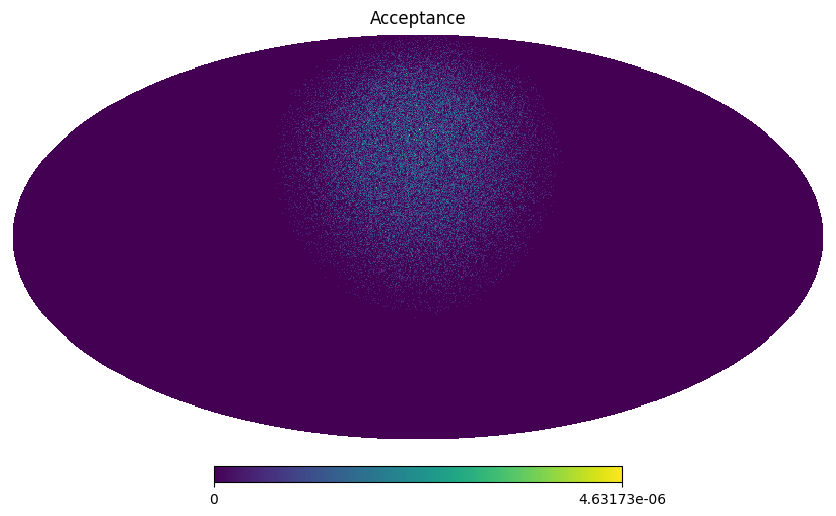

In [9]:
hp.mollview(Acceptance)
plt.title("Acceptance")

In [10]:
np.save(os.path.join(savePath,"Energybin.npy"),Energybin)
np.save(os.path.join(savePath,"Energycenter.npy"),Energycenter)
np.save(os.path.join(savePath,"Acceptance.npy"),Acceptance)
np.save(os.path.join(savePath,"All.npy"),All)

In [15]:
mjdbins = np.linspace(
    np.min(Exptdata["mjd"]) - 0.1,
    np.max(Exptdata["mjd"]) + 0.1,
    int((np.max(Exptdata["mjd"]) - np.min(Exptdata["mjd"])) * (4 * NSIDE)) + 1,
)
mjdcenter = (mjdbins[1:] + mjdbins[:-1]) / 2


In [16]:
mjd_content = np.zeros([len(Energybin)-1,len(mjdcenter)])

In [17]:
for Energy_i in range(len(Energycenter)):
    # print(isgamma_cut, Energy_i)
    need = np.where(
        (Exptdata["energy"] > Energybin[Energy_i])
        & (Exptdata["energy"] < Energybin[Energy_i + 1])
    )
    mjd_content[Energy_i],_ = np.histogram(Exptdata["mjd"][need],bins=mjdbins)

In [18]:
mjdbins_need = np.where(np.sum(mjd_content,axis=0)!=0)[0]

In [19]:
np.save(os.path.join(savePath, "mjdbegin.npy"), mjdbins[mjdbins_need])
np.save(os.path.join(savePath, "mjdend.npy"), mjdbins[mjdbins_need + 1])
np.save(os.path.join(savePath, "mjd_content.npy"), mjd_content[:, mjdbins_need])
mjdcenter = mjdcenter[mjdbins_need]
np.save(os.path.join(savePath, "mjdcenter.npy"), mjdcenter)
YBJ_Location = EarthLocation(lat=30.102 * u.deg, lon=90.522 * u.deg, height=4300 * u.m)
mjdtime = Time(mjdcenter, format="mjd", location=YBJ_Location)
mjdcenter_sidereal = mjdtime.sidereal_time("apparent").degree
np.save(os.path.join(savePath, "mjd_sidereal.npy"), mjdcenter_sidereal)


In [4]:
mjdcenter_sidereal = np.load(os.path.join(savePath, "mjd_sidereal.npy"))
Energybin = np.load(os.path.join(savePath, "Energybin.npy"))
Energycenter = np.load(os.path.join(savePath, "Energycenter.npy"))
mjdbins_begin = np.load(os.path.join(savePath, "mjdbegin.npy"))
mjdbins_end = np.load(os.path.join(savePath, "mjdend.npy"))

knowsource = np.load("/home2/hky/github/Gamma_Energy/find_source/data/knowsource.npy")

Exptdata = np.load(os.path.join(savePath, "Exptdata.npz"))
Exptdata = {key: Exptdata[key] for key in Exptdata}
Acceptance = np.load(os.path.join(savePath, "Acceptance.npy"))


In [5]:
pix_need = np.arange(NPIX)[np.where(Acceptance!= 0)]
Acceptance_need = Acceptance[pix_need]
theta, phi = hp.pix2ang(NSIDE, pix_need)


In [6]:
Background = np.zeros([ len(Energybin) - 1, NPIX])

In [10]:
for mjd_i in tqdm(range(len(mjdcenter_sidereal))):
    Background_pix = hp.ang2pix(
        NSIDE, theta, np.deg2rad(mjdcenter_sidereal[mjd_i]) - phi
    )
    rate = 1 / (
        1
        - np.sum(
            Acceptance[np.where(knowsource[Background_pix] == 1),],
        )
    )
    need = np.where(
        (Exptdata["mjd"] > mjdbins_begin[mjd_i])
        & (Exptdata["mjd"] < mjdbins_end[mjd_i])
        & (Exptdata["ismasked"] == 0)
    )
    N_background, _ = np.histogram(Exptdata["energy"][need], bins=Energybin)
    N_background = N_background * rate
    for i in range(len(Energycenter)):
        np.add.at(
            Background[i],
            Background_pix,
            N_background[i] * Acceptance_need,
        )


  0%|          | 0/1452014 [00:00<?, ?it/s]

KeyboardInterrupt: 